# Mean Variance Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real estate, Commodity, Treasury, Corporate Bond are included
#### This note use Developed Equity, Emerging Equity, LongTerm Treasury, Real Estate to calculate Mean-Varaiance Optimized portfolio
#### Result is driven from 2010 to 2021 market data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import quantstats
from scipy.optimize import minimize

from utils.index_data import index_data
from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import mv_rebalance_strategy

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

#### Load Data of each asset classes
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price)]

In [3]:
np.random.seed(180)
data_setting = {
    'start' : '2010-01-01',
    'end'   : '2021-06-30',
    'rebal_period':'1D'
}

data = index_data(**data_setting)
return_df = data.index_data_loading()
return_df = return_df[['msci_world','msci_emerging','bb_long_maturity','msci_real_estate']]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

# to draw benchmark
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1D',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()


In [4]:
## Test with 2018-2019 market data
#### 2020 had crisis due to COVID-19
#### Purpose is to visualize How Portfolio is constructed and Optimized with scipy package
#### Random weight plotting and optimal portfolio choice is visualized

In [5]:
return_df = return_df.loc['2018-01-01':'2019-12-31']
benchmark_yield_df = benchmark_yield_df.loc['2018-01-01':'2019-12-31']

In [6]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum((return_df.mean() * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [7]:
print("Max return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(ret.argmax(), round(100*ret.max(),2), round(sharpe[ret.argmax()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[ret.argmax(),0], all_weights[ret.argmax(),1], all_weights[ret.argmax(),2], all_weights[ret.argmax(),3]))
print("########################################################################################################")

print("Max risk adjusted return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(sharpe.argmax(), round(100*ret[sharpe.argmax()],2), round(sharpe.max(),2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[sharpe.argmax(),0], all_weights[sharpe.argmax(),1], all_weights[sharpe.argmax(),2], all_weights[sharpe.argmax(),3]))
print("########################################################################################################")

print("Min risk portfolio")
print("#{} with annual return {}% and sharpe {} ".format(vol.argmin(), round(100*ret[vol.argmin()],2), round(sharpe[vol.argmin()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[vol.argmin(),0], all_weights[vol.argmin(),1], all_weights[vol.argmin(),2], all_weights[vol.argmin(),3]))
print("########################################################################################################")


Max return portfolio
#9813 with annual return 4.28% and sharpe 0.3 
developed market stock:0.9378694266566124, emerging market stock:0.01634674336230447, global bond:0.03290778076507156, real_estate 0.01287604921601149
########################################################################################################
Max risk adjusted return portfolio
#4905 with annual return 3.5% and sharpe 0.65 
developed market stock:0.24683978829492703, emerging market stock:0.0026541784241235857, global bond:0.7155617257248957, real_estate 0.034944307556053655
########################################################################################################
Min risk portfolio
#8954 with annual return 3.36% and sharpe 0.62 
developed market stock:0.2072978897517067, emerging market stock:0.02568352406286699, global bond:0.7588686404427968, real_estate 0.008149945742629538
########################################################################################################


In [8]:
def get_ret_vol_sharpe(weight):
    weight = np.array(weight)
    ret = np.sum(return_df.mean() * weight) * 252
    vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
    # set risk free rate as 1.5%
    sharpe = (ret-0.015)/vol
    return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

def neg_sharpe(weight):
    # to use convex optimization, change sign to minus to solve minimization problem.
    return get_ret_vol_sharpe(weight)['sharpe'] * -1

def min_vol(weight):
    # to use convex optimization, finding minimum volatility doesn't require sign change
    return get_ret_vol_sharpe(weight)['volatility']

# constraint : sum of weight should be less than equal to 1
def check_sum(weight):
    #return 0 if sum of the weights is 1
    return np.sum(weight)-1

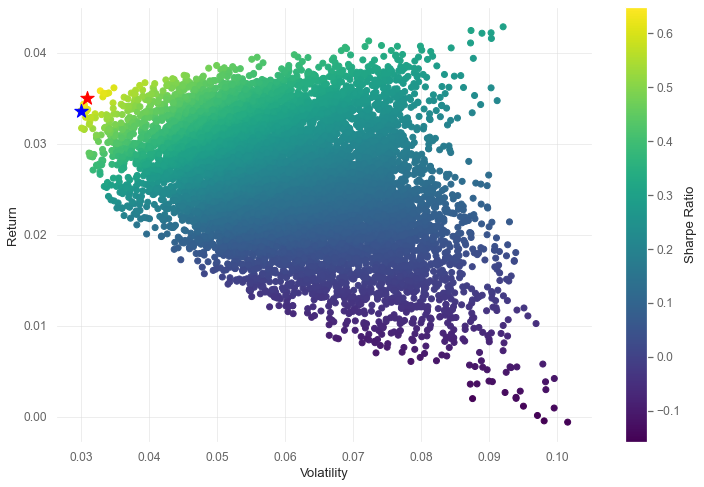

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()

In [10]:
cons = (
    {'type':'eq',
     'fun':check_sum}
)
bounds = ((0,1),(0,1),(0,1),(0,1))
initial = [0.25, 0.25, 0.25, 0.25] # 1/N weight for default

optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
print(optimizer)
print("Max Sharp portfolio consists of {}% of dm stock, {}% of em stock, {}% of fixed income, {}% of real_estate".format(round(100*optimizer.x[0],2), round(100*optimizer.x[1],2), round(100*optimizer.x[2],2), round(100*optimizer.x[3],2),))

     fun: -0.6665289694277907
     jac: array([-0.49280594,  0.87738676, -0.49475666, -0.11476256])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.26185821, 0.        , 0.73814179, 0.        ])
Max Sharp portfolio consists of 26.19% of dm stock, 0.0% of em stock, 73.81% of fixed income, 0.0% of real_estate


In [11]:
frontier_y = np.linspace(ret.min(), ret.max(), 200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sharpe(w)['return'] - possible_return})

    result = minimize(min_vol, initial, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

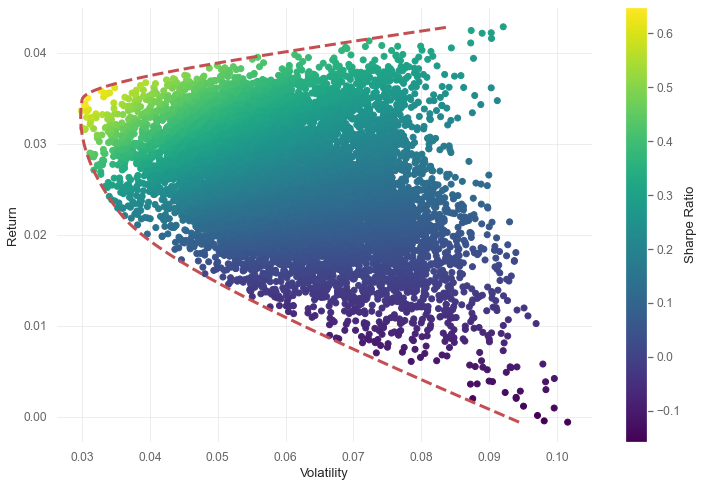

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()

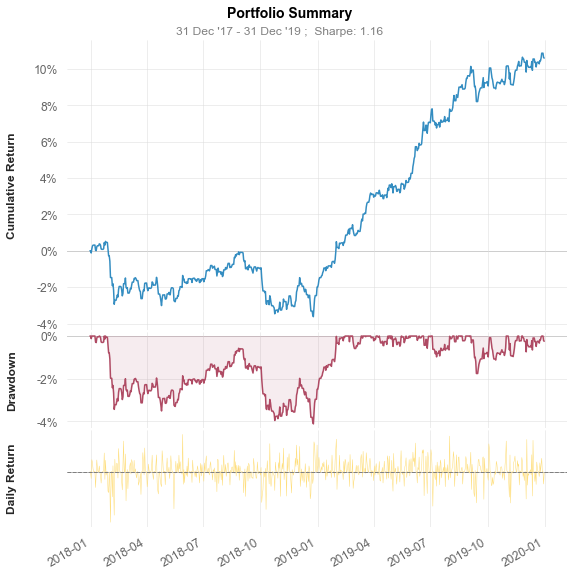

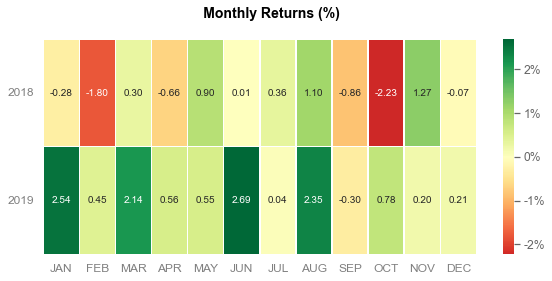

In [13]:
return_df['MV_Return'] = (optimizer.x[0]*return_df['msci_world'])\
                         + (optimizer.x[1]*return_df['msci_emerging']) \
                         + (optimizer.x[2]*return_df['bb_long_maturity']) \
                         + (optimizer.x[3]*return_df['msci_real_estate'])
quantstats.reports.plots(return_df['MV_Return'], mode='basic')

In [14]:
quantstats.reports.metrics(return_df['MV_Return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2018-01-01
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             72.0%

Cumulative Return          10.6%
CAGR﹪                     5.17%

Sharpe                     1.16
Smart Sharpe               1.13
Sortino                    1.68
Smart Sortino              1.64
Sortino/√2                 1.19
Smart Sortino/√2           1.16
Omega                      1.25

Max Drawdown               -4.12%
Longest DD Days            384
Volatility (ann.)          3.03%
Calmar                     1.26
Skew                       -0.31
Kurtosis                   2.42

Expected Daily %           0.01%
Expected Monthly %         0.42%
Expected Yearly %          5.16%
Kelly Criterion            11.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.3%
Expected Shortfall (cVaR)  -0.3%

Gain/Pain Ratio            0.25
Gain/Pain (1M)             1.65



## Backtest Mean-Variance stategy for long term period
#### index data is used to backtest long term
#### benchmark is all-weather portfolio of Ray-Dalio

In [15]:
np.random.seed(180)
data_setting = {
    'start' : '2010-01-01',
    'end'   : '2021-06-30',
    'rebal_period':'1D'
}

data = index_data(**data_setting)
return_df = data.index_data_loading()
return_df = return_df[['msci_world','msci_emerging','bb_long_maturity','msci_real_estate']]

bm_class_ticker =[
    "VTI", # Vanguard Total Stock Market ETF                        2001-05-24
    "TLT", # iShares 20+ Year Treasury Bond ETF                     2002-07-22
    "IEI", # iShares 3-7 Year Treasury Bond ETF                     2007-01-05
    "GLD", # SPDR Gold Trust                                        2004-11-18
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               2006-07-10
                    ]

# to draw benchmark
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-06-30',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1D',
}

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [16]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [17]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

In [18]:
def get_ret_vol_sharpe(weight):
    weight = np.array(weight)
    ret = np.sum(return_df.mean() * weight) * 252
    vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
    # set risk free rate as 1.5%
    sharpe = (ret-0.015)/vol
    return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

def neg_sharpe(weight):
    # to use convex optimization, change sign to minus to solve minimization problem.
    return get_ret_vol_sharpe(weight)['sharpe'] * -1

# constraint : sum of weight should be less than equal to 1
def check_sum(weight):
    #return 0 if sum of the weights is 1
    return np.sum(weight)-1

In [19]:
def max_sharpe_portfolio(weight):
    cons = (
        {'type':'eq',
         'fun':check_sum}
    )
    bounds = ((0,1),(0,1),(0,1),(0,1))
    initial = [0.25, 0.25, 0.25, 0.25] # 1/N weight for default

    optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
    print(optimizer)
    print("Max Sharp portfolio consists of follows:")
    print("{}% of dm stock".format(round(100*optimizer.x[0],2)))
    print("{}% of em stock".format(round(100*optimizer.x[1],2)))
    print("{}% of fixed income".format(round(100*optimizer.x[2],2)))
    print("{}% of real estate".format(round(100*optimizer.x[3],2)))

    return [
            round(optimizer.x[0],2),
            round(optimizer.x[1],2),
            round(optimizer.x[2],2),
            round(optimizer.x[3],2)
            ]

In [20]:
mean_variance_strategy = mv_rebalance_strategy(
    strategy=max_sharpe_portfolio(weights), yld_df=return_df,
    bm_strategy=all_weather_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=12
)

     fun: -0.6591543889723064
     jac: array([-0.37932894,  0.19853841, -0.37686832,  0.14667562])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.93407455e-01, 1.08306443e-15, 7.06592545e-01, 0.00000000e+00])
Max Sharp portfolio consists of follows:
29.34% of dm stock
0.0% of em stock
70.66% of fixed income
0.0% of real estate


In [21]:
mean_variance_strategy

,strategy_return,benchmark_return,msci_world,msci_emerging,bb_long_maturity,msci_real_estate,SUM
2010-01-13,-0.002591,-0.001667,0.29,0.0,0.71,0.0,1.0
2010-01-14,0.004228,0.006673,0.29,0.0,0.71,0.0,1.0
2010-01-15,0.000008,-0.002309,0.29,0.0,0.71,0.0,1.0
2010-01-16,0.0,-0.0,0.29,0.0,0.71,0.0,1.0
2010-01-17,0.0,-0.0,0.29,0.0,0.71,0.0,1.0
...,...,...,...,...,...,...,...
2021-06-26,0.0,-0.0,0.29,0.0,0.71,0.0,1.0
2021-06-27,0.0,-0.0,0.29,0.0,0.71,0.0,1.0
2021-06-28,0.002432,0.004488,0.29,0.0,0.71,0.0,1.0
2021-06-29,0.000262,0.000283,0.29,0.0,0.71,0.0,1.0


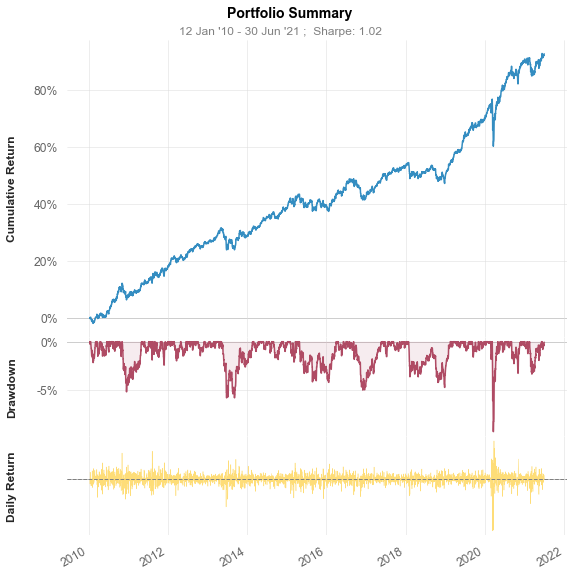

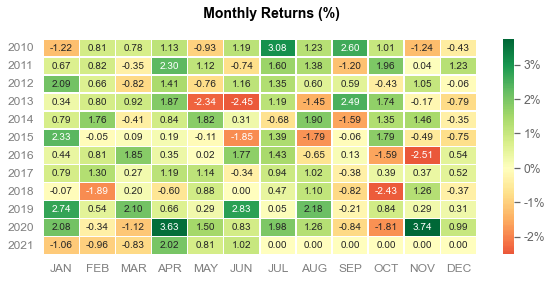

In [22]:
quantstats.reports.plots(mean_variance_strategy['strategy_return'], mode='basic')

In [23]:
quantstats.reports.metrics(returns=mean_variance_strategy['strategy_return'], benchmark=mean_variance_strategy['benchmark_return'],mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-13  2010-01-13
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             72.0%       100.0%

Cumulative Return          92.63%      149.49%
CAGR﹪                     5.88%       8.3%

Sharpe                     1.02        1.0
Smart Sharpe               0.99        0.97
Sortino                    1.45        1.4
Smart Sortino              1.42        1.37
Sortino/√2                 1.03        0.99
Smart Sortino/√2           1.0         0.97
Omega                      1.24        1.24

Max Drawdown               -9.33%      -14.1%
Longest DD Days            385         485
Volatility (ann.)          3.95%       5.68%
R^2                        0.73        0.73
Calmar                     0.63        0.59
Skew                       -0.72       -0.95
Kurtosis                   15.52       14.38

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-13  2010-01-13
End Period                 2021-06-30  2021-06-30
Risk-Free Rate             0.0%        0.0%
Time in Market             72.0%       100.0%

Cumulative Return          92.63%      149.49%
CAGR﹪                     5.88%       8.3%

Sharpe                     1.02        1.0
Smart Sharpe               0.99        0.97
Sortino                    1.45        1.4
Smart Sortino              1.42        1.37
Sortino/√2                 1.03        0.99
Smart Sortino/√2           1.0         0.97
Omega                      1.24        1.24

Max Drawdown               -9.33%      -14.1%
Longest DD Days            385         485
Volatility (ann.)          3.95%       5.68%
R^2                        0.73        0.73
Calmar                     0.63        0.59
Skew                       -0.72       -0.95
Kurtosis                   15.52       14.38

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-09,2020-03-18,2020-04-29,51,-9.328804,-8.506520
2,2013-05-03,2013-06-24,2014-02-25,298,-5.821624,-5.717968
3,2010-11-05,2010-12-15,2011-05-06,182,-5.198019,-4.746652
4,2016-09-08,2016-12-01,2017-05-22,256,-5.019099,-4.914105
5,2018-01-26,2018-12-25,2019-02-15,385,-4.744234,-4.225988


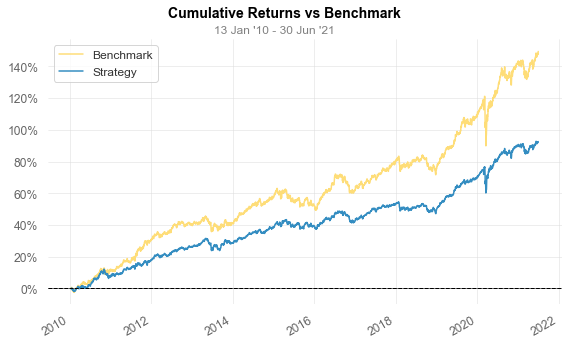

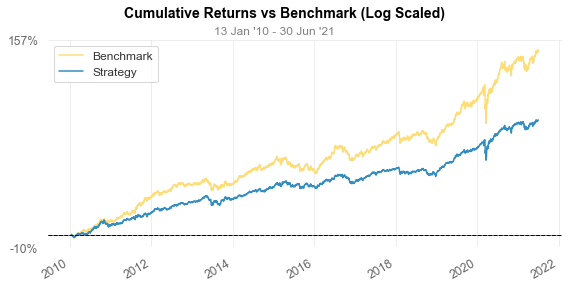

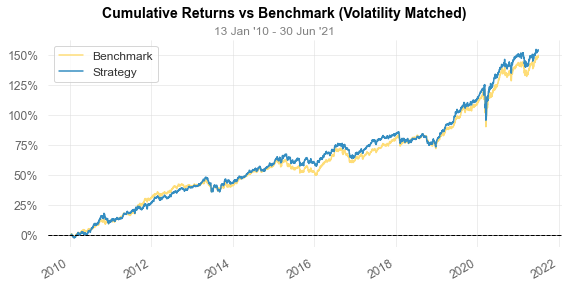

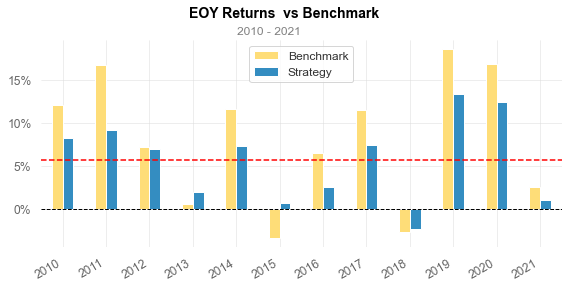

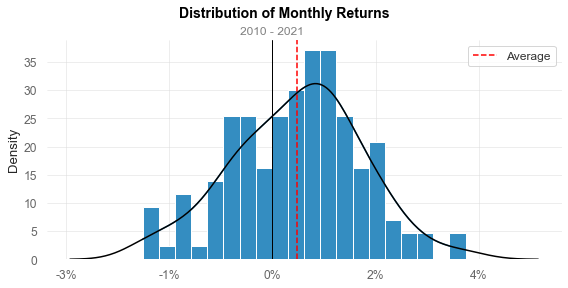

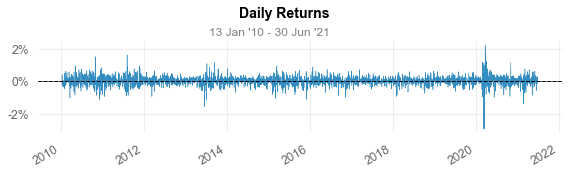

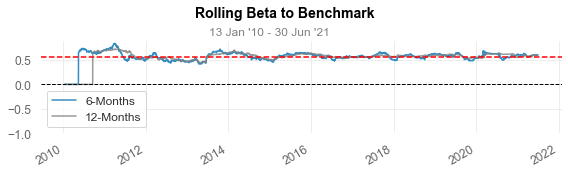

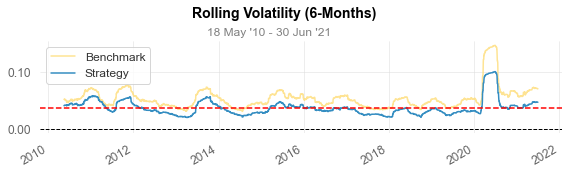

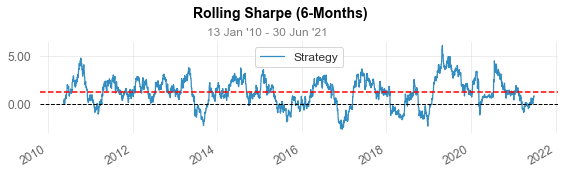

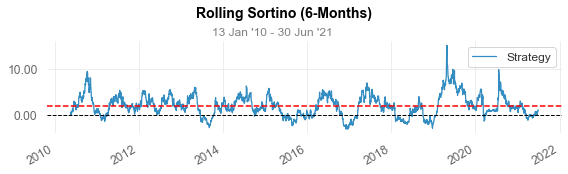

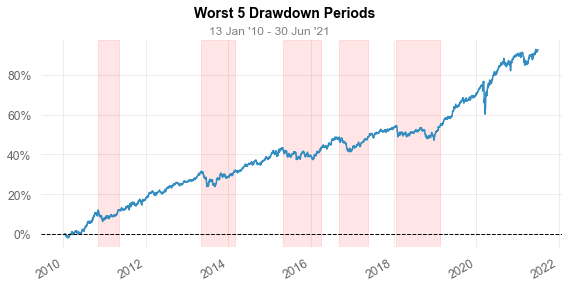

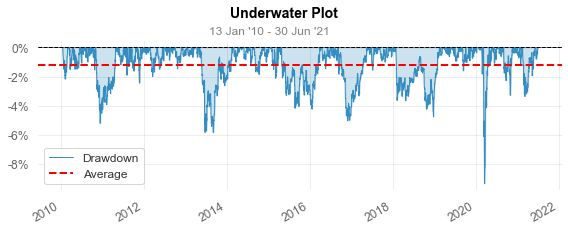

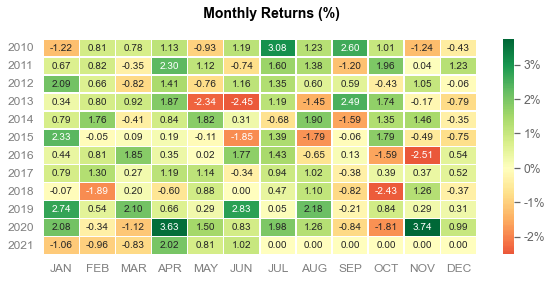

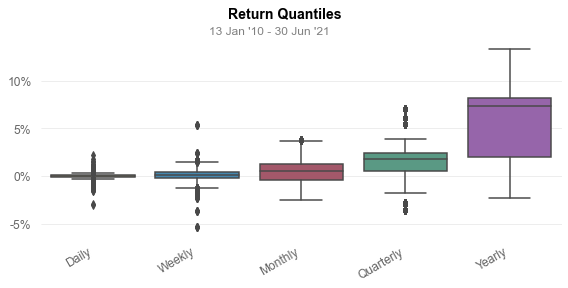

In [24]:
quantstats.reports.full(returns=mean_variance_strategy['strategy_return'], benchmark=mean_variance_strategy['benchmark_return'])